# Classifying SNe

This notebook identifies SN 1991bg-like SNe and compares the results of photometric and spectroscopic classifications.

#### Table of Contents:
1. <a href='#reading_in_data'>Reading in the Data</a>: Reading in data from both the analysis pipeline and external publications.
1. <a href='#photometric_classification'>Photometric Classification</a>: Subtyping of Photometrically observed targets.
1. <a href='#intrinsic_properties'>Intrinsic Properties</a>: Plots of fitted parameters from the classification proccess.
1. <a href='#host_properties'>Host Galaxy Properties</a>: Identification of trends with host galaxy mass and SSFR.


In [1]:
import sys
import warnings
from multiprocessing import Pool
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sndata.sdss import sako18
from tqdm.notebook import tqdm

sys.path.insert(0, '../')
from phot_class.classification import classify_targets

sako18.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/classification')
fig_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path('../results/').resolve()


## Reading in the Data <a id='reading_in_data'></a>

To save time later on, we read in all of the necessary data in advance. We start with the photometric classifications from SDSS.


In [2]:
# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)
sako_classification['spec_class'].value_counts()


Variable    3225
Unknown     2009
pSNII       1628
AGN          906
zSNIa        824
pSNIa        624
SNIa         499
zSNII        357
SNII          64
SNIa?         41
zSNIbc        40
pSNIbc        16
SNIc          12
SNIb          10
SLSN           3
Name: spec_class, dtype: int64

Next, we select only object Id's for targets with observations in at least two bands and at least one point before and after max.

In [3]:
def passes_cut(obj_id):
    """Determine if an object has data in >=2 bands and at
    least one point before and after max
    
    Args:
        obj_id (str): The object Id
        
    Returns:
        A boolean
    """
    
    obj_data = sako18.get_data_for_id(obj_id).to_pandas()
    obj_data = obj_data[obj_data.flux / obj_data.fluxerr >= 5]
    num_bands = len(obj_data.band.unique())
    salt2_fits = Table.read(results_dir / 'sdss_salt2_fits.ecsv').to_pandas(index='obj_id')

    try:
        salt_fit = salt2_fits.loc[obj_id]
        return all(
            (salt_fit.pre_max, salt_fit.post_max, (num_bands >= 2))
        )
        
    except KeyError:
        return False


def get_good_ids(cache_file):
    """Get SDSS object Ids for targets passing observation cuts
    
    Results are cached to file for performance.
    
    Args:
        cache_file (str): Path to cache return to
        
    Returns:
        An array of object Ids
    """
        
    if Path(cache_file).exists():
        return np.load(cache_file)
    
    sako_obj_ids = sako18.get_available_ids()
    with Pool() as p:
        is_good_id = list(tqdm(p.imap(passes_cut, sako_obj_ids), total=len(sako_obj_ids)))

    good_obj_ids = np.array(sako_obj_ids)[is_good_id].tolist()
    np.save(cache_file, good_obj_ids)
    return good_obj_ids


In [4]:
good_obj_ids = get_good_ids(results_dir / 'good_ids.npy')
good_obj_ids

array(['10028', '10037', '10045', ..., '9954', '996', '999'], dtype='<U5')

Finally, we read in the photometric fit results and determine the resulting classification coordinates for each object. We include results from SiFTO and from our own pipeline.


In [5]:
def read_phot_pipeline_results(path):
    """Read light-curve fits file and determie resulting classifications
    
    Classifications are cached to file for performance.
    
    Args:
        path (Path): Path of the fit results
    
    Returns: 
        - A dataframe with fit results
        - A dataframe with classification coordinates
    """

    phot_fits = Table.read(path)
    phot_fits = phot_fits[np.isin(phot_fits['obj_id'], good_obj_ids)]
    
    cache_path = path.with_name(path.name.replace('fits', 'class'))
    if cache_path.exists():
        phot_class = Table.read(cache_path)
        
    else:
        phot_class = classify_targets(phot_fits)
        phot_class.write(cache_path)
        
    phot_class = phot_class.to_pandas('obj_id')
    phot_fits = phot_fits.to_pandas().set_index(['source', 'obj_id'])
    phot_class = phot_class[(phot_class.x < 20) & (phot_class.y > -10)]
    return phot_fits, phot_class

def read_sifto_results(path):
    col_names = [
        'obj_id', 'RED', 'LC-DATA', 'ST', 'ST-err', 'COL', 'COL-err', 
        'BMAG', 'BMAG-err', 'CHI2DOF', 'MJDMAX', 'MJDMAX-err'
    ]
    
    df = pd.read_table(
        path,
        skiprows=[0],
        names=col_names,
        delim_whitespace=True,
        engine='python', 
    )
    
    df['chisq'] = df['CHI2DOF']
    df['ndof'] = 1
    
    # Replace IAU names with with SDSS object Id
    master = sako18.load_table('master')
    master = master[~master['IAUName'].mask]
    sn_id_map = dict(zip(master['IAUName'], master['CID']))
    df['obj_id'] = df['obj_id'].str.lstrip('SDSSsn').replace(sn_id_map)
    
    return df.set_index('obj_id')

def get_combined_sifto_results(results):
    
    sifto_dir = results / 'sifto'
    bg_blue = read_sifto_results(sifto_dir / 'sdss-91bg-blue' / 'fitinfo.dat')
    bg_red = read_sifto_results(sifto_dir / 'sdss-91bg-red' / 'fitinfo.dat')
    bg_all = read_sifto_results(sifto_dir / 'sdss-91bg' / 'fitinfo.dat')
    sdss_blue = read_sifto_results(sifto_dir / 'sdss-blue' / 'fitinfo.dat')
    sdss_red = read_sifto_results(sifto_dir / 'sdss-red' / 'fitinfo.dat')
    sdss_all = read_sifto_results(sifto_dir / 'sdss' / 'fitinfo.dat')
        
    classification_coords = pd.DataFrame({
        'x': bg_red['CHI2DOF'] - bg_blue['CHI2DOF'],
        'y': sdss_red['CHI2DOF'] - sdss_blue['CHI2DOF']
    }).dropna()
    
    # Yes I could use itertools here, but I don't feel like adding an import
    dataframes = (bg_blue, bg_red, bg_all, sdss_blue, sdss_red, sdss_all)
    sources = ('sn91bg', 'sn91bg', 'sn91bg', 'hsiao_x1', 'hsiao_x1', 'hsiao_x1')
    bands = ('blue', 'red', 'all', 'blue', 'red', 'all')
    for df, source, band in zip(dataframes, sources, bands):
        df['source'] = source
        df['band'] = band
        df.set_index('source', inplace=True, append=True)

    fits = pd.concat(dataframes).reorder_levels(['source', 'obj_id'])
    return fits, classification_coords
    

In [6]:
coll_path = results_dir / 'collective_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
coll_fits, coll_class = read_phot_pipeline_results(coll_path)

band_path = results_dir / 'band_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
band_fits, band_class = read_phot_pipeline_results(band_path)

sifto_fits, sifto_class = get_combined_sifto_results(results_dir)


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'pre_max' from integer to float
  
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'post_max' from integer to float
  
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:5: TableReplaceWarning: converted column 'pre_max' from integer to float
  """
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:5: TableReplaceWarning: converted column 'post_max' from integer to float
  """


In [7]:
band_fits.head()


message            band  pre_max  \
source   obj_id                                                               
hsiao_x1 10028   Minimization exited successfully.             all     85.0   
         10028   Minimization exited successfully.  sdss_sako18_g4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_i4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_r4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_u4     17.0   

                 post_max          vparams     mwebv         z  amplitude  \
source   obj_id                                                             
hsiao_x1 10028       20.0  t0,amplitude,x1  0.021712  0.064256   0.000219   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000212   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000237   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000223   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000209   

                           t0        x1  ...  mwebv_err  z_err  amplitude_err  \
source   obj_id                          ...                                    
hsiao_x1 10028   2.453694e+06 -0.141844  ...        NaN    NaN   7.311878e-07   
         10028   2.453694e+06 -0.134201  ...        NaN    NaN   8.785449e-07   
         10028   2.453694e+06 -0.109513  ...        NaN    NaN   1.762427e-06   
         10028   2.453694e+06 -0.107367  ...        NaN    NaN   9.081427e-07   
         10028   2.453694e+06 -0.225185  ...        NaN    NaN   3.735375e-06   

                  t0_err    x1_err  c_err   chisq  ndof  b_max  delta_15  
source   obj_id                                                           
hsiao_x1 10028   0.08593  0.006495    NaN  412.58  32.0 -19.16     1.330  
         10028       NaN  0.007464    NaN    9.06   5.0 -19.09     1.312  
         10028       NaN  0.017644    NaN   32.54   5.0 -19.33     1.258  
         10028       NaN  0.011104    NaN   44.56   5.0 -19.20     1.253  
         10028       NaN  0.026010    NaN    2.56   5.0 -19.06     1.544  

[5 rows x 21 columns]

## Photometric Classification <a id='photometric_classification'></a>

#### Section Contents:
1. <a href='#exploration_of_failed_fits'>Exploration of Failed Fits</a>: A preliminary exploration of the data.
1. <a href='#classification'>Classification</a>: Classifying photometrically observed targets.
1. <a href='#photometric_vs_spectroscopic'>Photometric V.S. Spectroscopic Classifications</a>: Compares the photometric and spectroscopic results


### Exploration of Failed Fits <a id='exploration_of_failed_fits'></a>

We perform a cursory investigation of any fits that have failed to converge. To start, we note the unique error messages raised in the band and collective fit results.

In [8]:
def get_failed_fits(fits_df):
    """Select failed fits from a dataframe"""
    
    failed_fits = fits_df.message.str.lower().str.contains('failed')
    return fits_df[failed_fits]
    

In [9]:
print('Band fit error messages:\n')
print(get_failed_fits(band_fits).message.unique())

print('\nCollective fit error messages:\n')
print(get_failed_fits(coll_fits).message.unique())


Band fit error messages:

['Hesse Failed. Covariance may not be accurate. Covariance not positive definite.'
 'No data points with S/N > 5.0. Initial guessing failed.']

Collective fit error messages:

['Hesse Failed. Covariance may not be accurate. Covariance not positive definite.'
 'No data points with S/N > 5.0. Initial guessing failed.']


The SNR error is not concerning so long as there are an equal number of occurences between the band and collective fits.

In [10]:
snr_err_msg = 'No data points with S/N > 5.0. Initial guessing failed.'
band_snr_indices = band_fits.message == snr_err_msg
collective_snr_indices = coll_fits.message == snr_err_msg
equal_errors = sum(band_snr_indices) == sum(collective_snr_indices)

print('Equal Number of SNR errors:', equal_errors)


Equal Number of SNR errors: True


We drop the SNR errors for now and look at the distribution of the remaining errors across bands and models.

In [11]:
band_fits_goodsnr = band_fits[band_fits.message != snr_err_msg]
collective_fits_goodsnr = coll_fits[coll_fits.message != snr_err_msg]


In [12]:
band_failed_nosnr = get_failed_fits(band_fits_goodsnr)

print('Band by band error distribution\n')
print('By fitted band (set):')
print(band_failed_nosnr.band.str[-2].value_counts())

print('\nNumber of failed fits per source:')
print(band_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(band_failed_nosnr.index.value_counts().value_counts())


Band by band error distribution

By fitted band (set):
z    17
r    17
u    17
i    15
g    14
l    12
Name: band, dtype: int64

Number of failed fits per source:
hsiao_x1    91
sn91bg       1
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
6     7
1     6
11    2
5     2
10    1
2     1
dtype: int64


### Classification <a id='classification'></a>

We apply the classification to the fitted light curves.

In [13]:
def calc_delta_chisq(fits_df):
    """Calculate the difference in reduced chisq for overall fits

    Args:
        fits_df (DataFrame): Pipeline fit results

    Returns:
        A pandas series
    """

    fits_hsiao = fits_df.loc['hsiao_x1']
    fits_hsiao = fits_hsiao[fits_hsiao.band == 'all']
    fits_sn91bg = fits_df.loc['sn91bg']
    fits_sn91bg = fits_sn91bg[fits_sn91bg.band == 'all']
    return (fits_hsiao.chisq / fits_hsiao.ndof) - (
            fits_sn91bg.chisq / fits_sn91bg.ndof)

def plot_chisq_scatter(fits_df):
    """Plot classification results

    Args:
        fits_df (DataFrame): DataFrame of fit results
    """
    
    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0].index
    chi_gt0 = delta_chi[delta_chi > 0].index

    all_fits =  fits_df[fits_df.band == 'all']
    chisq_hs = all_fits.loc['hsiao_x1'].chisq / all_fits.loc['hsiao_x1'].ndof
    chisq_bg = all_fits.loc['sn91bg'].chisq / all_fits.loc['sn91bg'].ndof
    chisq = pd.DataFrame(dict(chisq_hs=chisq_hs, chisq_bg=chisq_bg))

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    labels = (r'$\Delta\chi^2 < 0$', r'$\Delta\chi^2 > 0$')
    for index, label in zip((chi_lt0, chi_gt0), labels):
        plot_data = chisq.reindex(index)
        axis.scatter(plot_data.chisq_hs, plot_data.chisq_bg, 
                     s=5, alpha=.2, label=label)

    ylim = axis.get_ylim()
    axis.plot(ylim, ylim, linestyle='--', color='grey')
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel(r'Reduced Hsiao $\chi^2$')
    axis.set_ylabel(r'Reduced SN91bg $\chi^2$')
    axis.legend(framealpha=1)
    
    axis.set_xlim(0, 1e3)
    axis.set_ylim(0, 1e3)
    return fig, axis


In [14]:
sifto_fits.loc['hsiao_x1']

,RED,LC-DATA,ST,ST-err,COL,COL-err,BMAG,BMAG-err,CHI2DOF,MJDMAX,MJDMAX-err,chisq,ndof,band
obj_id,,,,,,,,,,,,,,
1114,0.026,0,1.410,0.032,0.024,0.066,15.406,0.036,40.151,53582.142,0.677,40.151,1,blue
1472,0.014,0,1.600,-0.000,NaN,NaN,NaN,NaN,57.516,53557.733,0.653,57.516,1,blue
2366,0.147,1,1.600,-0.000,NaN,NaN,NaN,NaN,2.360,53623.641,1.160,2.360,1,blue
2661,0.193,0,1.494,0.148,0.146,0.101,21.970,0.225,1.786,53614.424,6.250,1.786,1,blue
3818,0.051,1,1.306,0.014,0.562,0.160,19.907,0.027,205.729,53656.535,0.164,205.729,1,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22248,0.439,1,0.558,0.102,-0.391,0.048,21.324,0.079,1.549,54431.612,1.322,1.549,1,all
22255,0.121,0,0.854,2.509,0.034,0.326,20.539,0.986,0.101,54437.129,41.788,0.101,1,all
22256,0.000,1,1.600,0.000,NaN,NaN,NaN,NaN,0.791,54398.309,2.362,0.791,1,all


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


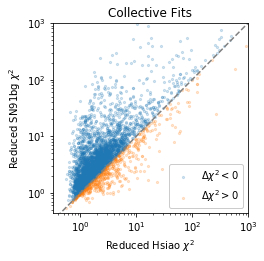

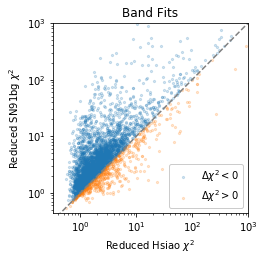

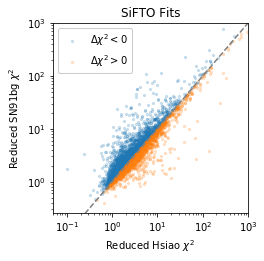

In [15]:
plot_chisq_scatter(coll_fits)
plt.title('Collective Fits')
plt.show()

plot_chisq_scatter(band_fits)
plt.title('Band Fits')
plt.show()

plot_chisq_scatter(sifto_fits)
plt.title('SiFTO Fits')
plt.show()


In [16]:
def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index) 
    flagged = flagged[flagged.Notes > 1]
    return flagged


def create_border_hist(axis, padding=0, xpos='top', ypos='right'):
    """Create axes for plotting border histograms

    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes
        xpos      (str): Put the x histogram on the 'top' or 'bottom'
        ypos      (str): Put the y histogram on the 'left' or 'right'

    Returns:
        Axis for the upper histogram
        Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    if xpos == 'top':
        histx_pos = axis.get_position()
        histx_pos.y0 += axis_height + padding
        histx_pos.y1 = histx_pos.y1 + .35 * axis_height + padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=False)
        
    elif xpos == 'bottom':
        histx_pos = axis.get_position()
        histx_pos.y1 -= axis_height + padding
        histx_pos.y0 = histx_pos.y1 - .35 * axis_height - padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=True)

    if ypos == 'right':
        histy_pos = axis.get_position()
        histy_pos.x0 += axis_width + padding
        histy_pos.x1 = histy_pos.x1 + .35 * axis_width + padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=False)
        
    elif ypos == 'left':
        histy_pos = axis.get_position()
        histy_pos.x1 -= axis_width + padding
        histy_pos.x0 = histy_pos.x1 - .35 * axis_width - padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=True)

    return histx, histy


def plot_classification(class_df, fits_df, border_bins, padding, xpos='top', ypos='right', fig=None, axis=None):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
        fits_df   (DataFrame): DataFrame of fit results
        border_bins (ndarray): Bins for histogram
        padding       (float): Spacing between the main and bordering axes
        xpos            (str): Put the x histogram on the 'top' or 'bottom'
        ypos            (str): Put the y histogram on the 'left' or 'right'
        fig          (Figure): Optionally use an existing figure
        axis           (Axis): Optionally use an existing axis
    """

    if fig is None or axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
        
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
    labels = {2: '91bg', 3: '00cx', 4: '02ci', 5: '02cx'}

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    sako_pec = get_sako_pec()
    all_data_lt = class_df.reindex(chi_lt0.index).drop(sako_pec.index, errors='ignore')
    all_data_gt = class_df.reindex(chi_gt0.index).drop(sako_pec.index, errors='ignore')
    
    axis.scatter(all_data_lt.x, all_data_lt.y, s=10, alpha=.7)
    axis.scatter(all_data_gt.x, all_data_gt.y, s=10, color='C1', alpha=.7)
    
    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=12, labelpad=10)
    axis.set_ylabel(y_label, fontsize=12)
    axis.set_xlim(min(border_bins), max(border_bins))
    axis.set_ylim(-50, 50)
    
    for flag_type, flag_data in sako_pec.groupby('Notes'):
        plt_data = class_df.reindex(flag_data.index)
        marker = markers[flag_type]
        label = labels[flag_type]
        axis.scatter(plt_data.x, plt_data.y, s=20, 
                     marker=marker, zorder=9,
                     color='k', label=label, facecolor='none')

    histx, histy = create_border_hist(axis, padding, xpos=xpos, ypos=ypos)
    histx.hist([all_data_lt.x, all_data_gt.x], bins=border_bins, stacked=True)
    histy.hist([all_data_lt.y, all_data_gt.y], bins=border_bins,
               stacked=True, orientation='horizontal')

    histx.set_xlim(axis.get_xlim())
    histy.set_ylim(axis.get_ylim())
    histx.set_yscale('log')
    histy.set_xscale('log')
    return fig, axis, [histx, histy]


def plot_classification_with_subtypes():
    fig, axes = plt.subplots(2, 2, figsize=(7.5, 7.5), sharex=True, sharey=True)
    coll_fig, coll_axes, hist_axes = plot_classification(
        class_df=iminuit_band_class, 
        fits_df=iminuit_band_fits, 
        border_bins=np.arange(-100, 100, 5),
        padding=.01, 
        fig=fig, 
        axis=axes[0, 1]
    )
    
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axes[0, 0].set_ylabel(y_label)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    axes[1, 0].set_ylabel(y_label)
    axes[1, 0].set_xlabel(x_label)
    axes[1, 1].set_xlabel(x_label)
    hist_axes[0].set_ylim(0, 1e4)
    hist_axes[1].set_ylim(0, 1e4)

    categories = [
        ['SNIa', 'pSNIa', 'zSNIa', 'SNIa?'], 
        ['SNII', 'pSNII', 'zSNII'],
        ['pSNIbc', 'zSNIbc', 'SNIc', 'SNIb', 'SNIbc']
    ]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sdss_pd = sdss_master.to_pandas()
        sdss_pd['obj_id'] = sdss_pd['CID']
        sdss_pd.set_index('obj_id', inplace=True)
        class_with_sdss = iminuit_coll_class.join(sdss_pd)

    for axis, cat in zip(axes.flatten()[[0, 2, 3]], categories):
        category_data = class_with_sdss[np.isin(class_with_sdss.Classification, cat)]
        for st, data in category_data.groupby('Classification'):
            axis.scatter(data.x, data.y, label=st, alpha=.75, s=20)
            axis.axvline(0, color='grey', linestyle='--')
            axis.axhline(0, color='grey', linestyle='--')
            axis.legend()

    plt.xlim(-100, 100)
    plt.ylim(-50, 50)



In [17]:
def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index) 
    flagged = flagged[flagged.Notes > 1]
    return flagged


def create_border_hist(axis, padding=0, xpos='top', ypos='right'):
    """Create axes for plotting border histograms

    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes
        xpos      (str): Put the x histogram on the 'top' or 'bottom'
        ypos      (str): Put the y histogram on the 'left' or 'right'

    Returns:
        Axis for the upper histogram
        Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    if xpos == 'top':
        histx_pos = axis.get_position()
        histx_pos.y0 += axis_height + padding
        histx_pos.y1 = histx_pos.y1 + .35 * axis_height + padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=False)
        
    elif xpos == 'bottom':
        histx_pos = axis.get_position()
        histx_pos.y1 -= axis_height + padding
        histx_pos.y0 = histx_pos.y1 - .35 * axis_height - padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=True)

    if ypos == 'right':
        histy_pos = axis.get_position()
        histy_pos.x0 += axis_width + padding
        histy_pos.x1 = histy_pos.x1 + .35 * axis_width + padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=False)
        
    elif ypos == 'left':
        histy_pos = axis.get_position()
        histy_pos.x1 -= axis_width + padding
        histy_pos.x0 = histy_pos.x1 - .35 * axis_width - padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=True)

    return histx, histy


def plot_classification(
    class_df, fits_df, xbins, ybins,
    padding=0.05, xpos='top', ypos='right', 
    fig=None, axis=None, legend=False):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
        fits_df   (DataFrame): DataFrame of fit results
        border_bins (ndarray): Bins for histogram
        padding       (float): Spacing between the main and bordering axes
        xpos            (str): Put the x histogram on the 'top' or 'bottom'
        ypos            (str): Put the y histogram on the 'left' or 'right'
        fig          (Figure): Optionally use an existing figure
        axis           (Axis): Optionally use an existing axis
    """

    if fig is None or axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
        
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
    labels = {2: '1991bg', 3: '2000cx', 4: '2002ci', 5: '2002cx'}

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    sako_pec = get_sako_pec()
    all_data_lt = class_df.reindex(chi_lt0.index).drop(sako_pec.index, errors='ignore')
    all_data_gt = class_df.reindex(chi_gt0.index).drop(sako_pec.index, errors='ignore')
    
    axis.scatter(all_data_lt.x, all_data_lt.y, s=7, alpha=.5)
    axis.scatter(all_data_gt.x, all_data_gt.y, s=7, color='C1', alpha=.5)
    
    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=10, labelpad=10)
    axis.set_ylabel(y_label, fontsize=10)
    axis.set_xlim(min(xbins), max(xbins))
    axis.set_ylim(min(ybins), max(ybins))
    axis.xaxis.set_minor_locator(MultipleLocator(5))
    axis.yaxis.set_minor_locator(MultipleLocator(5))
    
    for flag_type, flag_data in sako_pec.groupby('Notes'):
        plt_data = class_df.reindex(flag_data.index)
        marker = markers[flag_type]
        label = labels[flag_type]
        axis.scatter(plt_data.x, plt_data.y, s=20, 
                     marker=marker, zorder=9,
                     color='k', label=label, facecolor='none')

    histx_norm, histy_norm = create_border_hist(axis, padding, xpos=xpos, ypos=ypos)
    histx_bg = histx_norm.twinx()
    histy_bg = histy_norm.twiny()
    
    histx_norm.hist(all_data_lt.x, bins=xbins, color='C0')
    histx_bg.hist(all_data_gt.x, bins=xbins, histtype='step', color='C1')
    
    histy_norm.hist(all_data_lt.y, bins=ybins, color='C0', orientation='horizontal')
    histy_bg.hist(all_data_gt.y, bins=ybins, histtype='step', color='C1', orientation='horizontal')

    histx_norm.set_xlim(axis.get_xlim())
    histy_norm.set_ylim(axis.get_ylim())
    
    if legend:
        axis.legend()
        
    return fig, axis, histx_norm, histy_norm


In [18]:
a = np.logspace(-1, 2, 10)
bins = list(-a[::-1]) + list(a)
x_bins = y_bins = bins


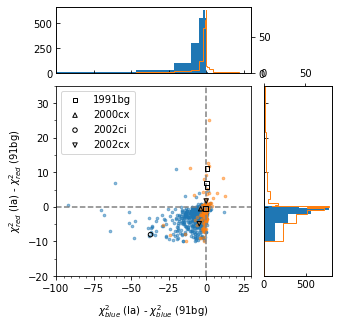

In [19]:
band_fig, band_axis, band_histx, band_histy = plot_classification(
    class_df=band_class, 
    fits_df=band_fits, 
    xbins=x_bins,
    ybins=y_bins,
    legend=True
)

band_axis.set_ylim(-20, 35)
band_histy.set_ylim(band_axis.get_ylim())

band_axis.set_xlim(-100, 30)
band_histx.set_xlim(band_axis.get_xlim())

plt.savefig(fig_dir / 'band_classification.pdf', bbox_inches='tight')
plt.show()


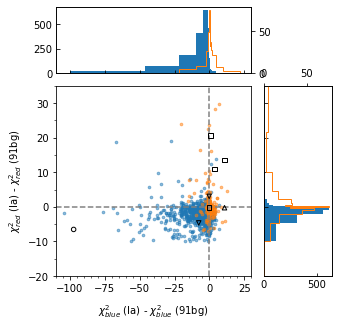

In [20]:
coll_fig, coll_axis, coll_histx, coll_histy = plot_classification(
    class_df=coll_class, 
    fits_df=coll_fits, 
    xbins=x_bins,
    ybins=y_bins
)

coll_axis.set_ylim(-20, 35)
coll_histy.set_ylim(coll_axis.get_ylim())

coll_axis.set_xlim(-110, 30)
coll_histx.set_xlim(coll_axis.get_xlim())

plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


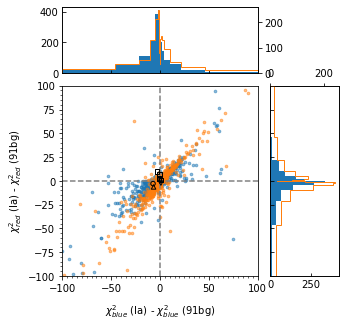

In [21]:
sifto_fig, sifto_axis, sifto_histx, sifto_histy = plot_classification(
    class_df=sifto_class, 
    fits_df=sifto_fits, 
    xbins=x_bins,
    ybins=y_bins
)
    
plt.savefig(fig_dir / 'sifto_classification.pdf', bbox_inches='tight')
plt.show()


In [22]:
def plot_classification_with_subtypes(classification_coords):
    fig, axes = plt.subplots(2, 2, figsize=(7.5, 7.5), sharex=True, sharey=True)
    
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axes[0, 0].set_ylabel(y_label)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    axes[1, 0].set_ylabel(y_label)
    axes[1, 0].set_xlabel(x_label)
    axes[1, 1].set_xlabel(x_label)

    categories = [
        {'Spectroscopic SNe Ia': ['SNIa', 'SNIa?'], 'Photometric SNe Ia': ['pSNIa', 'zSNIa']},
        {'Spectroscopic SNe II': ['pSNII', 'zSNII'], 'Photometric SNe II': ['SNII']},
        {'Spectroscopic SNe Ibc': ['SNIc', 'SNIb', 'SNIbc'], 'Photometric SNe Ibc': ['pSNIbc', 'zSNIbc']},
        {'Unknown': 'Unknown'}
    ]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sdss_pd = sako18.load_table('master').to_pandas()
        sdss_pd['obj_id'] = sdss_pd['CID']
        sdss_pd.set_index('obj_id', inplace=True)
        class_with_sdss = classification_coords.join(sdss_pd)

    sako_pec = get_sako_pec()
    for axis, category_dict in zip(axes.flatten(), categories):
        for cat_label, cat_list in category_dict.items():
        
            category_data = class_with_sdss[np.isin(class_with_sdss.Classification, cat_list)]
            # category_data.drop(sako_pec.index, errors='ignore', inplace=True)
            axis.axvline(0, color='grey', linestyle='--', zorder=0)
            axis.axhline(0, color='grey', linestyle='--', zorder=0)
            axis.scatter(category_data.x, category_data.y, label=f'{cat_label} ({len(category_data)})', alpha=.7, s=8)
            axis.legend(loc='upper left', framealpha=1)

            # markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
            # labels = {2: '91bg', 3: '00cx', 4: '02ci', 5: '02cx'}
            # for flag_type, flag_data in sako_pec.groupby('Notes'):
            #     plt_data = category_data.reindex(flag_data.index)
            #     marker = markers[flag_type]
            #     axis.scatter(plt_data.x, plt_data.y, s=20, 
            #                  marker=marker, zorder=9,
            #                  color='k', facecolor='none')


    # ylabels = np.arange(-50, 51, 10)
    # ylabels_str = np.array(ylabels, dtype='str')
    # ylabels_str[::2] = ''
    # plt.yticks(ylabels, ylabels_str)
    # 
    # xlabels = np.arange(-100, 101, 20)
    # xlabels_str = np.array(xlabels, dtype='str')
    # xlabels_str[::2] = ''
    # plt.xticks(xlabels, xlabels_str)
    
    plt.subplots_adjust(wspace=.1, hspace=.1)
    
    axis.set_xlim(-110, 110)
    axis.set_ylim(-110, 110)
    axis.xaxis.set_minor_locator(MultipleLocator(5))
    axis.yaxis.set_minor_locator(MultipleLocator(5))
    


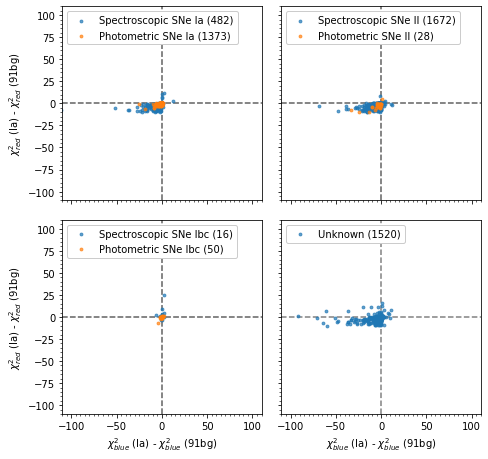

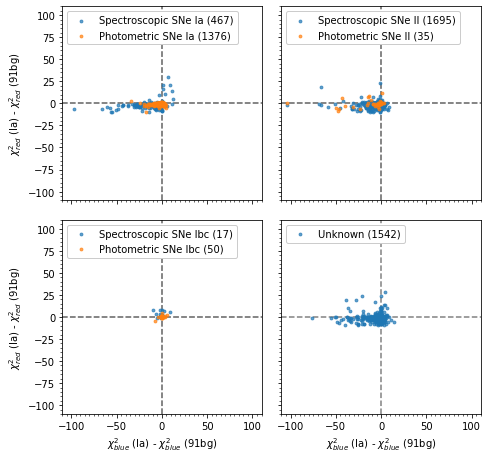

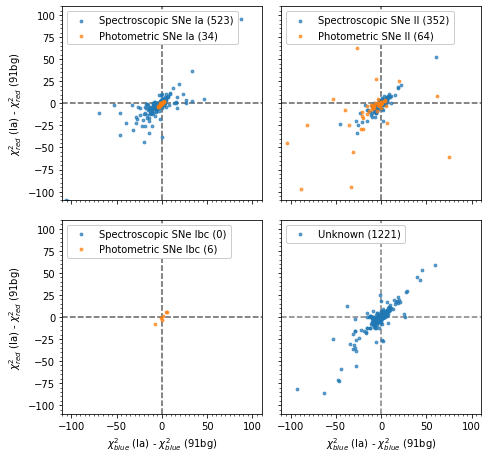

In [23]:
data_iter = (band_class, coll_class, sifto_class)
fnames = ('band', 'coll', 'sifto')
for classification_data, fname in zip(data_iter, fnames):
    plot_classification_with_subtypes(classification_data)
    plt.savefig(fig_dir / f'{fname}_sub_classification.pdf', bbox_inches='tight')
    plt.show()


## Intrinsic Properties <a id='intrinsic_properties'></a>

We consider the distribution of fit parameters.

In [24]:
def plot_param_histogram(fits_df, source, fit_type, param):
    """Plot a histagram of fit parameters
    
    Args:
        fits_df (DataFrame): Fit results
        source        (str): Name of the model to display results for
        fit_type      (str): Use "band" or "collective" fit results
        param         (str): Name of the parameter to plot
    """
    
    # Select data to plot
    fits_using_source = fits_df.loc[source]
    hist_data = fits_using_source[fits_using_source['band'] == 'all'][param]
    
    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    axis.hist(hist_data, bins=20)
    
    latex_safe_source = source.split("_")[0]
    axis.set_title(param + f' Distribution ({latex_safe_source} - {fit_type} Fits)'.title())
    axis.set_xlabel(param)
    axis.set_ylabel('Combined number of targets')   


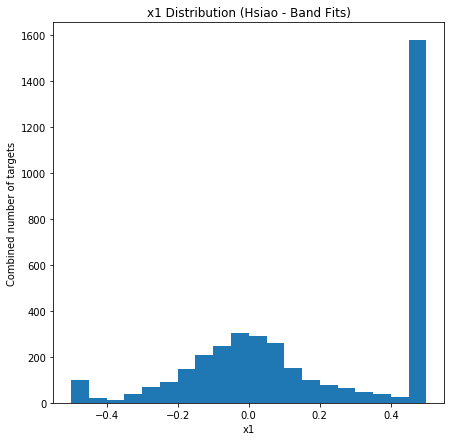

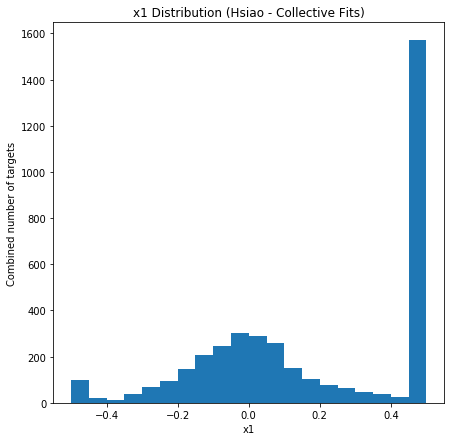

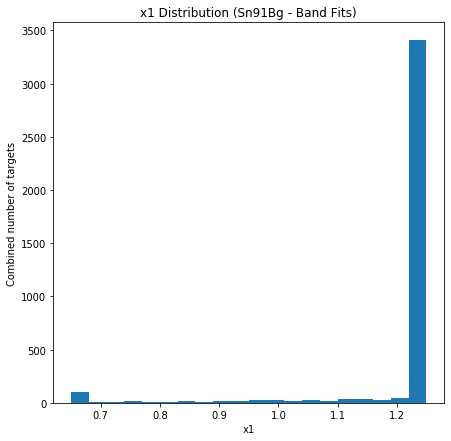

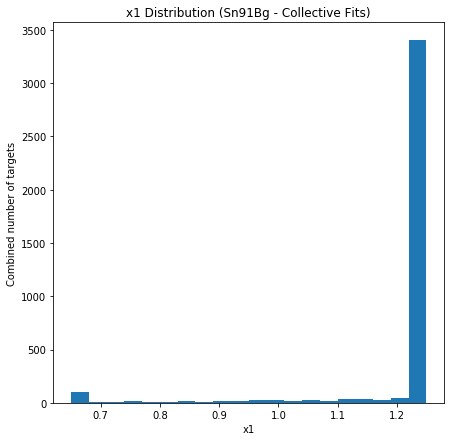

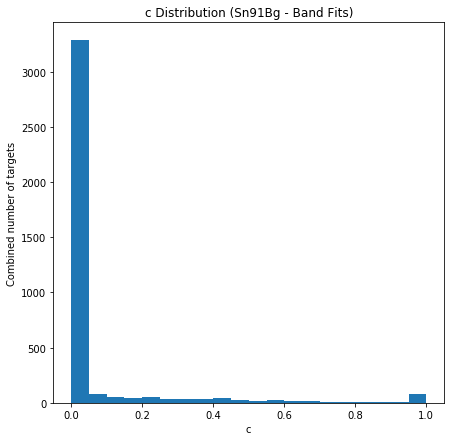

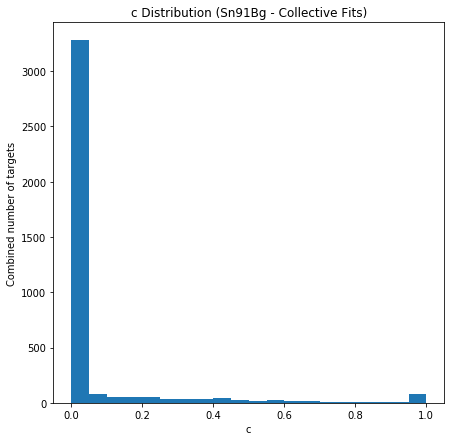

In [25]:
for source in ('hsiao_x1', 'sn91bg'):
    for param in ('x1', 'c'):
        if source == 'hsiao_x1' and param == 'c':
            continue
            
        for fit_type, fit_data in zip(('band', 'collective'), (band_fits, coll_fits)):
            plot_param_histogram(fit_data, source, fit_type, param)
            plt.savefig(fig_dir / f'{param}_{source}_{fit_type}_fits.pdf'.lower())
            plt.show()


In [26]:
x_cut = .25
y_cut = .25

ia_categories = ['SNIa', 'pSNIa', 'zSNIa', 'SNIa?', 'Unknown']
ia_indices = sdss_master['CID'][np.isin(sdss_master['Classification'], ia_categories)]
ia_subtyped = iminuit_coll_class.reindex(ia_indices)

bg_like = ia_subtyped[(ia_subtyped.x > x_cut) & (ia_subtyped.y > y_cut)].index
normal = ia_subtyped[(ia_subtyped.x < x_cut) & (ia_subtyped.y < y_cut)].index
print(len(bg_like))


NameError: name 'iminuit_coll_class' is not defined

In [ ]:
bg_like

In [ ]:
import sncosmo
from phot_class.models import register_sources

register_sources(True)
sako18.register_filters(True)

dust_kw = dict(effects=[sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])
sn91bg = sncosmo.Model(sncosmo.get_source('sn91bg', version='hsiao_phase'), **dust_kw)
hsiao = sncosmo.Model('hsiao_x1', **dust_kw)
salt2 = sncosmo.Model('salt2', **dust_kw)


In [ ]:
def convert_to_zp(data, zp):
    """Convert the flux and fluxerr columns of a table to a new zp
    
    Returns a copy
    
    Args:
        data (Table): The table to modify
        zp (float): The new zp
    
    Returns:
        An astropy Table
    """
    
    data = data.copy()
    conv_factor = 10 ** ((data['zp'] - zp) / -2.5)
    data['flux'] *= conv_factor
    data['fluxerr'] *= conv_factor
    data['zp'] = zp
    return data


In [ ]:
all_fits = iminuit_coll_fits[iminuit_coll_fits.band == 'all']

for obj_id in bg_like:
    obj_data = convert_to_zp(sako18.get_data_for_id(obj_id), 20).to_pandas()
    sn91bg.update({p: getattr(all_fits.loc['sn91bg', obj_id], p) for p in sn91bg.param_names})
    hsiao.update({p: getattr(all_fits.loc['hsiao_x1', obj_id], p) for p in hsiao.param_names})
    salt2.update({p: getattr(salt2_fits.loc[obj_id], p) for p in salt2.param_names})
    model_time = np.arange(obj_data.time.min() - 20, obj_data.time.max() + 20)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True, sharex=True)
    for axis, band in zip(axes, 'ugriz'):
        band_data = obj_data[obj_data['band'].str.contains(band)]
        if not len(band_data):
            continue
        
        observed_time = band_data.time - 2453000
        axis.errorbar(observed_time, band_data.flux, band_data.fluxerr, color='k', linestyle='None')
        axis.scatter(observed_time, band_data.flux, color='k', label=f'{band}-band', s=10)
        
        band_name = band_data.band.iloc[0]
        zp = band_data.zp.iloc[0]
        
        for model in (sn91bg, hsiao, salt2):
            model_names = {'sn91bg': 'SN91bg', 'salt2': 'Salt2', 'hsiao_x1': 'Hsiao'}
            label = model_names[model.source.name] if band == 'u' else None
            try:
                model_flux = model.bandflux(band_name, model_time, zp, 'AB') 
                axis.plot(model_time - 2453000, model_flux, label=label)
                
            except ValueError:
                pass
        
        axis.set_ylim(0, obj_data.flux.max() * 1.1)
        
        if obj_id == '6415':
            axis.set_ylim(0, 2)
            
        if obj_id == '12780':
            axis.set_ylim(0, 5)
            
        if obj_id == '19382':
            axis.set_ylim(0, 1)
            
        axis.legend(loc='upper right', framealpha=1)
        axis.set_xlabel('Time (MJD - 53000)', fontsize=12)
    
    axes[0].set_ylabel(f'Flux (ZP = {zp})', fontsize=12)
    axes[2].set_title(f'Object {obj_id}')
    plt.tight_layout()
    
    out_dir = Path('./notebook_figs/light_curves/')
    out_dir.mkdir(exist_ok=True, parents=True)
    plt.savefig(out_dir / f'{obj_id}.pdf')
    plt.show()



In [ ]:
bg_like = ['6295', '12780', '15381',
                '15489', '15529', '16215', '17695', '17868',
                '17886', '18643', '18751', '18890', '19065', '20994', '21898']

### Host Galaxy Properties <a id='host_properties'></a>

We start with some book keeping and create dataframes for various subsets of the host galaxy data.

In [ ]:
host_photometry = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'host_id': sdss_master['objIDHost'],  # Host galaxy object ID in SDSS DR8 Database 
    'ra': sdss_master['RAhost'],  # Right ascension of galaxy host (degrees) 
    'dec': sdss_master['DEChost'],  # Declination of galaxy host (degrees) 
    'dist': sdss_master['separationhost'], # Distance from SN to host (arcsec) 
    'distnorm': sdss_master['DLRhost'], # Normalized distance from SN to host (dDLR) 
    'z_KF': sdss_master['zphothost'], # Host photometric redshift (KF algorithm) 
    'z_KF_err': sdss_master['zphoterrhost'], # zphothost uncertainty
    'z_RF': sdss_master['zphotRFhost'],  # Host photometric redshift (RF algorithm) 
    'z_RF_err': sdss_master['zphotRFerrhost'],  # zphotRFhost uncertainty 
    'u_mag': sdss_master['dereduhost'],  # Host galaxy u-band magnitude (dereddened) 
    'u_mag_err': sdss_master['erruhost'], # Host galaxy u-band magnitude uncertainty 
    'g_mag': sdss_master['deredghost'],  # Host galaxy g-band magnitude (dereddened)
    'g_mag_err': sdss_master['errghost'],  #  Host galaxy g-band magnitude uncertainty 
    'r_mag': sdss_master['deredrhost'],  # Host galaxy r-band magnitude (dereddened)
    'r_mag_err': sdss_master['errrhost'],  #  Host galaxy r-band magnitude uncertainty 
    'i_mag': sdss_master['deredihost'], # Host galaxy i-band magnitude (dereddened) 
    'i_mag_err': sdss_master['errihost'], # Host galaxy i-band magnitude uncertainty 
    'z_mag': sdss_master['deredzhost'], # Host galaxy z-band magnitude (dereddened) 
    'z_mag_err': sdss_master['errzhost'] # Host galaxy z-band magnitude (dereddened)
})
host_photometry.set_index('obj_id', inplace=True)
    
# Galaxy Parameters Calculated with FSPS
fsps_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassFSPS'],  # FSPS log(M), M=Galaxy Mass (M in units of Me)
    'logmass_lo' : sdss_master['logMassloFSPS'],  # FSPS Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiFSPS'],  # FSPS Upper limit of uncertainty in log(M)
    'logssfr' : sdss_master['logSSFRFSPS'],  # FSPS log(sSFR) sSFR=Galaxy Specific Star-forming Rate (SFR in Me yr−1)
    'logssfr_lo' : sdss_master['logSSFRloFSPS'],  # FSPS Lower limit of uncertainty in log(sSFR)
    'logssfr_hi' : sdss_master['logSSFRhiFSPS'],  # FSPS Upper limit of uncertainty in log(sSFR)
    'age' : sdss_master['ageFSPS'],  # FSPS galaxy age (Gyr)
    'age_lo' : sdss_master['ageloFSPS'],  # FSPS Lower limit of uncertainty in age
    'age_hi' : sdss_master['agehiFSPS'],  # FSPS Upper limit of uncertainty in age 
    'rchisq' : sdss_master['minredchi2FSPS'] # Reduced chi-squared of best FSPS template fit
})
fsps_params.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with PÉGASE.2
pegase_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassPEGASE'], # PÉGASE.2 log(M), M=Galaxy Mass (M in units of Me) 
    'logmass_lo' : sdss_master['logMassloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR) 
    'logssfr' : sdss_master['logSFRPEGASE'], # PÉGASE.2 log(SFR) SFR=Galaxy star-forming rate (Me yr−1)
    'logssfr_lo' : sdss_master['logSFRloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(SFR)
    'logssfr_hi' : sdss_master['logSFRhiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR)
    'age' : sdss_master['agePEGASE'], # PÉGASE.2 galaxy age (Gyr)
    'rchisq' : sdss_master['minchi2PEGASE']# Reduced chi-squared of best PÉGASE.2 fit
})
pegase_params.set_index('obj_id', inplace=True)


We also determine the distance of each SN to it's host in kiloparsecs.

In [ ]:
# Get the redshift values as a pandas array
sdss_table_2 = sako18.load_table(2)
sdss_table_2['obj_id'] = sdss_table_2['CID']
redshift = sdss_table_2['obj_id', 'zspecHelio'].to_pandas('obj_id')

# Add distance in kpc
host_photometry['arcmin'] = host_photometry.dist / 60
host_photometry['kpc'] = wmap9.kpc_comoving_per_arcmin(host_photometry.arcmin)


In [ ]:
def plot_host_property_distribution(col_name, bg_ids, normal_ids, *data_frames, **kwargs):
    """Plot histograms of host galaxy properties
    
    Args:
    col_name           (str): The name of the value to plot
    bg_ids          (Series): Object Ids of 91bg like SN
    normal_ids      (Series): Object Ids of normal SN
    *data_frames (DataFrame): Data frames with host galaxy data

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    

    num_cols = len(data_frames)
    fig, axes = plt.subplots(1, num_cols, figsize=(6, 3.5))  #, sharex=True, sharey=True)
    if len(data_frames) == 1:
        axes = np.array([axes])
    
    for df, axis in zip(data_frames, axes.flatten()):
        
        plot_data = df[col_name]
        bg_data = plot_data.reindex(bg_ids).dropna()
        normal_data = plot_data.reindex(normal_ids).dropna()
        
        aks = stats.anderson_ksamp([normal_data, bg_data])
        sig_level = aks.significance_level
        
        _, bins, _ = axis.hist(
            normal_data,
            density=True,
            label=f'Normal ({len(normal_data)})', 
            **kwargs
        )
        
        axis.hist(bg_data, 
                  fill=False, 
                  hatch='///', 
                  density=True, 
                  histtype='step', 
                  label=f'91bg ({len(bg_data)})',
                  bins=bins
                 )
        
        title = r'(p $\geq$ 0.25)' if sig_level == 0.25 else f'(p = {sig_level:.2})'
        axis.set_title(title)

    plt.tight_layout()
    
    return fig, axes
        

In [ ]:
fig, axes = plot_host_property_distribution(
    'age', bg_like, normal, fsps_params, pegase_params, 
    bins=np.arange(0, 20.1, .5)) 

axes[0].set_ylabel('Normalized Distribution', fontsize=14)
axes[0].set_title('FSPS ' + axes[0].get_title())

axes[1].set_title('PEGASE ' + axes[1].get_title())

for axis in axes:
    axis.set_xlim(0, 20)
    axis.set_xlabel('Stellar Age (Gyr)', fontsize=14)
    axis.legend(loc='upper right')
    
plt.savefig(fig_dir / 'collective_fits_age.pdf', bbox_inches='tight')
plt.show()


In [ ]:
fig, axes = plot_host_property_distribution(
    'logmass', bg_like, normal, fsps_params, pegase_params, bins=np.arange(7.5, 12.5, .25)) 

axes[0].set_ylabel('Normalized Distribution', fontsize=14)
axes[0].set_title('FSPS ' + axes[0].get_title())

axes[1].set_title('PEGASE ' + axes[1].get_title())

for axis in axes:
    axis.set_xlabel(r'$\log($M / M$_\odot)$', fontsize=14)
    axis.legend(loc='upper left')
    
plt.savefig(fig_dir / 'collective_fits_mass.pdf', bbox_inches='tight')
plt.show()


In [ ]:
pegase_ssfr = pegase_params[pegase_params.logssfr > -98]
fsps_ssfr = fsps_params.copy()
fsps_ssfr['logssfr'] /= 9

fig, axes = plot_host_property_distribution('logssfr', bg_like, normal, fsps_ssfr, pegase_ssfr, bins=30) 

axes[0].set_ylabel('Normalized Distribution', fontsize=14)
axes[0].set_title('FSPS ' + axes[0].get_title())
#axes[0].xaxis.set_major_locator(MultipleLocator(.5))
#axes[0].xaxis.set_minor_locator(MultipleLocator(.1))
# axes[0].set_xlim(0, 2)
axes[1].set_ylim(0, 2.5)
axes[0].set_xlim(-3, 0)
axes[1].set_title('PEGASE ' + axes[1].get_title())

for axis in axes:
    axis.set_xlabel('sSFR (yr$^{-1}$)', fontsize=14)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
plt.savefig(fig_dir / 'collective_fits_ssfr.pdf', bbox_inches='tight')
plt.show()


In [ ]:
fig, axes = plot_host_property_distribution(
    'kpc', bg_like, normal, host_copy, bins=np.arange(0, 500, 20)) 

#fig.set_size_inches(3, 3)
axes[0].set_xlabel('Distance to Host Center (kpc)', fontsize=14)
axes[0].set_ylabel('Normalized Distribution', fontsize=14)
axes[0].xaxis.set_major_locator(MultipleLocator(40))
axes[0].xaxis.set_minor_locator(MultipleLocator(20))
axes[0].set_xlim(0, 240)

plt.savefig(fig_dir / 'collective_fits_distance.pdf', bbox_inches='tight')
plt.show()


In [ ]:
host_copy = host_photometry.copy()
host_copy = host_copy[host_copy['kpc'] < 200]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_pvalue(class_df, data, max_x=3, max_y=3, x_cutoff=0, y_cutoff=0, size=30, vmin=None, vmax=None, cmap='Blues'):
    """Plot the p-value for host galaxy data as a function of cutoff value
    
    Args:
        class_df (DataFrame): Classification coordinates
        data        (Series): Host galaxy
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    sig_arr = np.zeros((size, size))
    count_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, sig_arr.shape[0])
    y_arr = np.linspace(0, max_y, sig_arr.shape[1])
    
    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            test_normal = class_df[(class_df.x < xcut) & (class_df.y < ycut)].index
            test_bg_data = data.reindex(test_bg).dropna()
            test_normal_data = data.reindex(test_normal).dropna()
            sig = stats.anderson_ksamp([test_normal_data, test_bg_data]).significance_level
            sig_arr[i, j] = sig
    
    fig, axis = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 4))
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axis.imshow(sig_arr, extent=extent, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    axis.set_xlabel('x Cutoff', fontsize=14)
    axis.set_ylabel('y Cutoff', fontsize=14)
    axis.set_xlim(0, max_x)
    axis.set_ylim(0, max_y)
    axis.set_xticks(np.arange(0, max_x + .1, .5))
    axis.set_yticks(np.arange(0, max_y + .1, .5))
    
    axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
    axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')
    
    cax.set_ylabel(r'$p$-value', fontsize=14, rotation=270, labelpad=20)
    
    return fig, axis, cax


In [ ]:
_, mass_axis, _ = plot_pvalue(
    iminuit_coll_class, fsps_params.logmass, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

mass_axis.set_title('Host Mass (FSPS)', fontsize=14)
plt.savefig(fig_dir / 'fsps_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

_, age_axis, _ = plot_pvalue(
    iminuit_coll_class, fsps_params.age, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

age_axis.set_title('Host Age (FSPS)', fontsize=14)
plt.savefig(fig_dir / 'fsps_age_pvalue.pdf', bbox_inches='tight')
plt.show()

# plot_pvalue(iminuit_coll_class, pegase_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut) 
# plt.savefig(fig_dir / 'pegase_mass_pvalue.pdf', bbox_inches='tight')
# plt.show()

_, ssfr_axis, ssfr_cax = plot_pvalue(
    iminuit_coll_class, fsps_params.logssfr, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

ssfr_axis.set_title('sSFR (FSPS)', fontsize=14)
plt.savefig(fig_dir / 'fsps_ssfr_pvalue.pdf', bbox_inches='tight')
plt.show()

_, dist_axis, dist_cax = plot_pvalue(
    iminuit_coll_class, host_photometry.dist, 
    x_cutoff=x_cut, y_cutoff=y_cut,
    size=50, vmin=.001, vmax=0.006
) 

dist_axis.set_title('Host Distance')
plt.savefig(fig_dir / 'dist_pvalue.pdf', bbox_inches='tight')
plt.show()


In [ ]:
_, mass_axis, _ = plot_pvalue(
    iminuit_coll_class, pegase_params.logmass, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

mass_axis.set_title('Host Mass (PEGASE)', fontsize=14)
plt.savefig(fig_dir / 'pegase_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

_, age_axis, _ = plot_pvalue(
    iminuit_coll_class, pegase_params.age, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

age_axis.set_title('Host Age (PegPEGASEase)', fontsize=14)
plt.savefig(fig_dir / 'pegase_age_pvalue.pdf', bbox_inches='tight')
plt.show()

_, ssfr_axis, ssfr_cax = plot_pvalue(
    iminuit_coll_class, pegase_params.logssfr, 
    x_cutoff=x_cut, y_cutoff=y_cut, 
    size=50) 

ssfr_axis.set_title('sSFR (PEGASE)', fontsize=14)
plt.savefig(fig_dir / 'pegase_ssfr_pvalue.pdf', bbox_inches='tight')
plt.show()



In [ ]:
def plot_num_points(class_df, data, max_x=3, max_y=3, x_cutoff=0, y_cutoff=0, size=30):
    """Plot the number of 91bgs as a function of the x and y cutoffs
    
    Args:
        class_df (DataFrame): Classification coordinates
        data        (Series): Host galaxy
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    count_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, count_arr.shape[0])
    y_arr = np.linspace(0, max_y, count_arr.shape[1])
    
    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            test_bg_data = data.reindex(test_bg).dropna()
            count_arr[i, j] = len(test_bg_data)
    
    # fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))
    # for axis, plot_data in zip(axes, (count_arr, sig_arr)):
    fig, axis = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))
    
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = axis.imshow(count_arr, extent=extent, origin='lower', cmap='Blues', vmin=0, vmax=50)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
    axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')

    axis.set_ylabel('y Cutoff', fontsize=10)
    axis.set_xlabel('x Cutoff', fontsize=10)
    axis.set_title('Number of 91bg points', fontsize=10)
    axis.contour(x_arr, y_arr, count_arr, levels=np.arange(0, 51, 10), colors='k')
    axis.contour(x_arr, y_arr, count_arr, levels=np.arange(5, 26, 5), colors='k', linestyles=':')
    axis.set_xlim(0, max_x)
    axis.set_ylim(0, max_y)
    axis.set_xticks(np.arange(0, max_x + .1, .5))
    axis.set_yticks(np.arange(0, max_y + .1, .5))
    cax_labels = cax.get_yticklabels
    
    cax.set_yticks(np.arange(0, 51, 10))
    cax.set_yticklabels(['0', '10', '20', '30', '40', r'$\geq$50'])
    cax.set_ylabel(r'Number of Points', fontsize=10, rotation=270, labelpad=12)
    
    return fig, axis


In [ ]:
plot_num_points(iminuit_coll_class, fsps_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut, size=50) 
plt.savefig(fig_dir / 'num_points.pdf', bbox_inches='tight')


In [ ]:
bg_like